In [198]:
import numpy as np
import sxs
import scipy
import gw_eccentricity
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(0, "./tools")
import loading
import decomposition
from importlib import reload
reload(loading)
reload(decomposition)

<module 'decomposition' from '/urania/u/pjn/gitrepos/EccentricWaveformDecomposition/./tools/decomposition.py'>

In [200]:
IDs = ["04", "35", "84"]
N_runs = np.size(IDs)
extrapolation_order = 2
project = "SurveyMeanAno_v2"
wfs, metadata, horizon = loading.LoadData(IDs, extrapolation_order, project)
h22 = loading.RestrictTo22Mode(wfs, IDs)
h22_total = loading.CutJunk(h22, IDs, junk_time=500)
h22 = loading.RestrictToFirstPeriastron(h22, IDs)
h22 = loading.RestrictToInspiral(h22, IDs)
h22 = loading.Align(h22, IDs)
h22 = decomposition.AddMeanAnomalyDomain(h22, IDs)

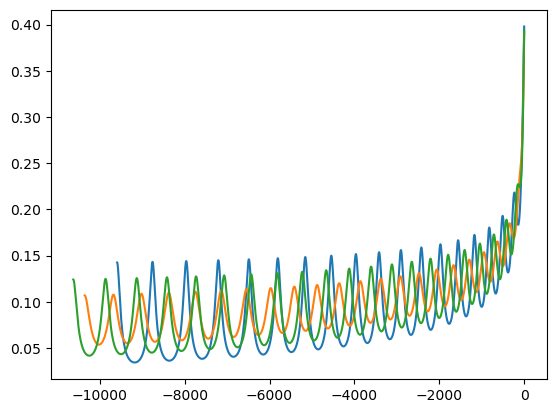

In [201]:
for k in range(N_runs):
    plt.plot(h22[IDs[k]]["t"], np.abs(h22[IDs[k]]["h22"]))

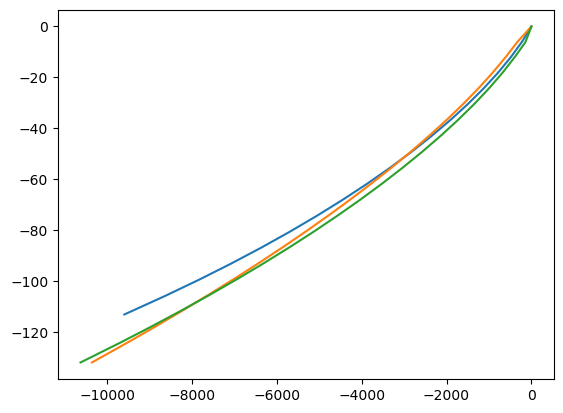

In [202]:
for k in range(N_runs):
    plt.plot(h22[IDs[k]]["t"], h22[IDs[k]]["MeanAno"])

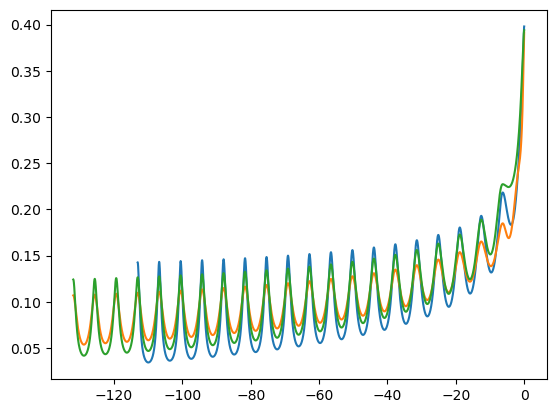

In [203]:
for k in range(N_runs):
    plt.plot(h22[IDs[k]]["MeanAno"], np.abs(h22[IDs[k]]["h22"]))